# Data processing and stochastic modelization

In [1]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

RERUN = False #To rerun all computations (False will load from file if they exist)
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/' #On desktop
#DIR  = 'C:/Users/Antoine/Documents/Etudes/Master CSE/pdm/data/' #On laptop

In [2]:
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}

In [3]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

def Extract_param (fname, param) :
    p_dict = {}
    for p_ in param :
        k  = 0
        for i in range(len(DIR),len(fname)) :
            if fname[i:i+len(p_)] == p_ :
                k = i+len(p_)
                break
        v_ = ''
        while (fname[k] != '_' and fname[k:k+2] != '.d') :
            v_ += fname[k]
            k  += 1
        p_dict[p_] = float(v_)
    return p_dict

# Loading and processing DNS data

##### Computing Ux mean from Eulerian velocities

In [4]:
UMEAN = {}
Ndat  = 1000
if (not os.path.isfile(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')) :
    phi   = Bentheimer1000['phi']
    print('-load ux data..')
    ux    = np.loadtxt(DIR+'Bentheimer'+str(Ndat)+'/Ux.dat')
    print('-Ux dimensions : '+str(np.shape(ux)))
 
    #First method to find Umean (direct mesh computation)
    print('-first method..')
    Umean = np.mean(ux[:][0]) #Mean flow velocity as the mean over the first yz section of the domain
    UMEAN['dmc'] = [Umean]

    #Second method (From Fortran code)
    print('-reshaping ux..')
    uux = ux.reshape(Ndat**3)
    del ux
    Umean = 0
    print('-second method..')
    for (i2,i3) in zip(range(Ndat),range(Ndat)) :
        i1 = 0
        Umean += uux[Ndat*Ndat*i3 + Ndat*i2 + i1]
    Umean = Umean/(Ndat**2)/phi
    UMEAN['fortran'] = [Umean]
    Save_data(UMEAN,DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    del uux
else :
    UMEAN = Load_data(DIR+'Processed_data/UMEAN'+str(Ndat)+'.dat')
    
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
print('=> Umean fortran = ' + str(UMEAN['fortran']) + '\t Umean dmc = ' + str(UMEAN['dmc']))
Umean = UMEAN['fortran'][0]

=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]
=> Umean fortran = [2.4514361e-09]	 Umean dmc = [7.17953958e-09]


#### Data files 

In [5]:
DATA = {}
DM_ = ['0.0E-9',
       '1.0E-13',
       '2.0E-13', 
       '5.0E-13', 
       '1.0E-12',
       '2.0E-12', 
       '5.0E-12', 
       '1.0E-11', 
       '2.0E-11', 
       '5.0E-11', 
       '1.0E-10',
       '2.0E-10',
       '5.0E-10',
       '1.0E-9',
       '2.0E-9',
       '5.0E-9',
       '1.0E-8'
      ]
KEYS   = ['Bent 1000, D='+dm+', CSF=20' for dm in DM_] #ORDERED ARRAY OF KEYS (IMPORTANT TO SORT DATA)
for dm in DM_ : DATA['Bent 1000, D='+dm+', CSF=20'] = DIR+'Bentheimer1000/sl_out_M0_DM'+dm+'_SLSM0_TMAX1E7_CSF20.dat'
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]
COLORS = {key : color for (key,color) in zip(PLOT_KEYS,color_cycle)}
print('Dataset to load : ' +str(len(DATA)))
PARAM = {}
param = ['DM','SLSM','TMAX','CSF']
for key in DATA : PARAM[key] = Extract_param (DATA[key],param)
D_VALUES = [PARAM[key]['DM'] for key in KEYS]

Dataset to load : 17


#### Computing log velocity magnitude $$v = \ln{\left(\frac{\sqrt{u_x^2 + u_y^2 + u_z^2}}{U}\right)}$$

In [6]:
vDNS = {}; vfname = DIR+'Processed_data/vDNS.dat'
tDNS = {}; tfname = DIR+'Processed_data/tDNS.dat'

if os.path.isfile(vfname) and os.path.isfile(tfname): 
    print('Loading fnames...')
    vDNS = Load_data(vfname)
    tDNS = Load_data(tfname)
    print('Done.')

RESAVE = False
print('Checking if new data file...')
for key in KEYS :
    if key not in vDNS :
        RESAVE = True
        print("missing " + key + "data..")
        with open(DATA[key], 'r') as f:
            lines   = (line for line in f if len(line)>15)
            dataDNS = np.genfromtxt(lines)
        del lines;
        tDNS[key] = dataDNS[:,0]
        print(key + '\t: NtDNS = '+str(len(tDNS[key])))
        vDNS[key] = np.array(
            [np.log(np.sqrt(ux**2+uy**2+uz**2)/Umean) 
                for (ux,uy,uz) in zip(dataDNS[:,4], dataDNS[:,5], dataDNS[:,6]) 
                if np.sqrt(ux**2+uy**2+uz**2) > 0])
        del dataDNS
if RESAVE :
    print('Saving...')
    Save_data(vDNS,DIR+'Processed_data/vDNS.dat')
    Save_data(tDNS,DIR+'Processed_data/tDNS.dat')
    print('Done.')
else : print('Done.')

Loading fnames...
Done.
Checking if new data file...
Done.


#### DNS log velocity magnitude PDF

In [7]:
def Extract_pdf(data_, nbins = 500, dst = True) :
    pdf_ = np.histogram(data_, bins = nbins, density = dst);
    pdf_ = np.array([pdf_[1][0:-1], pdf_[0]])
    return pdf_

def Return_mean(pdf_) :
    x = pdf_[0]; y = pdf_[1];
    return np.sum(x*y)/np.sum(y)

def Return_std(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu = Return_mean(pdf_)
    std  = np.sqrt(np.sum([(x_ - mu)**2*y_ for (x_,y_) in zip(x,y)])/np.sum(y))
    return std

def Return_skew(pdf_) :
    x    = pdf_[0]; y = pdf_[1];
    mu   = Return_mean(pdf_)
    std  = Return_std(pdf_)
    skew = np.sum([((x_ - mu)/std)**3*y_ for (x_,y_) in zip(x,y)])/np.sum(y)
    return skew

def mean_crossing_time(tdata) :
    T_  = []
    tm1 = 0
    for t_ in tdata :
        if tm1 > t_ : #If time is set to zero again (= end of the stream line)
            T_.append(tm1)
        tm1 = t_
    N_  = len(T_)
    mean_ = sum(T_)/N_
    return mean_

In [8]:
pdf_DNS = {} #Log velocity magnitude probability density function extracted directly from DNS
vmean   = [] #Mean log velocity magnitude
MCT     = [] #Mean crossingt time
for key in KEYS :
    pdf_DNS[key] = Extract_pdf(vDNS[key])
    MCT.append(mean_crossing_time(tDNS[key]))
    vmean.append(Return_mean(pdf_DNS[key]))

#### DNS velocity magnitude pdf and mean velocity magnitude for different diffusion coefficients

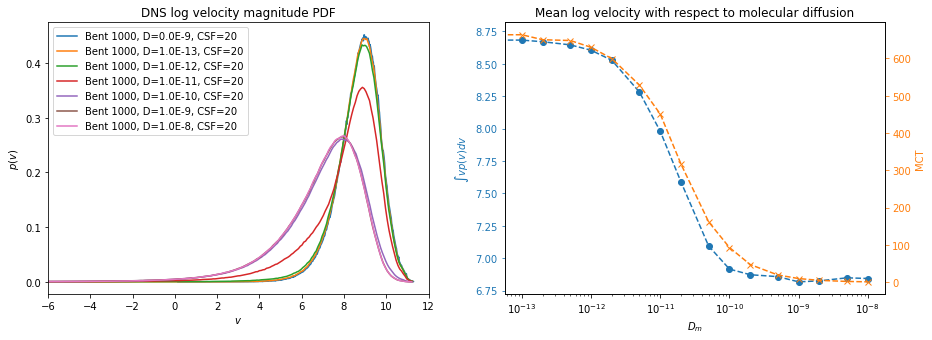

In [9]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]

axs[0].set_title('DNS log velocity magnitude PDF')
for key in PLOT_KEYS : axs[0].plot(pdf_DNS[key][0], pdf_DNS[key][1],label = key)
axs[0].legend();
axs[0].set_xlabel(r'$v$');
axs[0].set_ylabel(r'$p(v)$');
axs[0].set_xlim([-6,12]);

axs[1].set_title('Mean log velocity with respect to molecular diffusion')
axs[1].semilogx(D_VALUES,vmean,'o--', color = color_cycle[0])
axs[1].set_xlabel(r'$D_m$');
axs[1].set_ylabel(r'$\int vp(v)dv$', color=color_cycle[0])
axs[1].tick_params('y', colors=color_cycle[0])

ax3 = axs[1].twinx()
ax3.semilogx(D_VALUES,MCT,'x--', color = color_cycle[1])
ax3.set_ylabel('MCT', color=color_cycle[1])
ax3.tick_params('y', colors=color_cycle[1])
plt.savefig(DIR+'Figures/DNS_lvm_pdf'+extension)

#### DNS directional velocities pdf and mean velocity for different diffusion coefficients

In [10]:
def Save_pdf(pdf_dict, filename) :
    #Copy data into non np array dict for json formating
    x = {}
    y = {}
    for key in pdf_dict : x[key] = [v for v in pdf_dict[key][0]]
    for key in pdf_dict : y[key] = [v for v in pdf_dict[key][1]]
    with open(filename, 'w') as outfile:  
        json.dump([x,y], outfile)
        
def Load_pdf(filename) :
    x = {}
    y = {} 
    pdf_ = {}
    with open(filename, 'r') as outfile:  
        data = json.load(outfile)
    x = data[0]
    y = data[1]
    for key in x : pdf_[key] = [np.array(x[key]),np.array(y[key])]
    
    return pdf_

In [11]:
pvx_DNS = {}; vxmean = []; pdfvxfname = DIR+'Processed_data/pdf_vx.dat'
pvy_DNS = {}; vymean = []; pdfvyfname = DIR+'Processed_data/pdf_vy.dat'
pvz_DNS = {}; vzmean = []; pdfvzfname = DIR+'Processed_data/pdf_vz.dat'
RERUN  = False
if RERUN :
    for key in KEYS :
        print (key)
        with open(DATA[key], 'r') as f:
            lines   = (line for line in f if len(line)>15)
            dataDNS = np.genfromtxt(lines)
        del lines;
        pvx_DNS[key] = Extract_pdf(dataDNS[:,4]/Umean)
        pvy_DNS[key] = Extract_pdf(dataDNS[:,5]/Umean)
        pvz_DNS[key] = Extract_pdf(dataDNS[:,6]/Umean)
    del dataDNS    
    Save_pdf(pvx_DNS,pdfvxfname)
    Save_pdf(pvy_DNS,pdfvyfname)
    Save_pdf(pvz_DNS,pdfvzfname)
else :
    pvx_DNS = Load_pdf(pdfvxfname)
    pvy_DNS = Load_pdf(pdfvyfname)
    pvz_DNS = Load_pdf(pdfvzfname)

In [12]:
for key in KEYS :
    vxmean.append(Return_mean(pvx_DNS[key]))
    vymean.append(Return_mean(pvy_DNS[key]))
    vzmean.append(Return_mean(pvz_DNS[key]))

#### Comparison between mean velocity magnitude and mean directional velocities (in log) for various diffusion coefficients

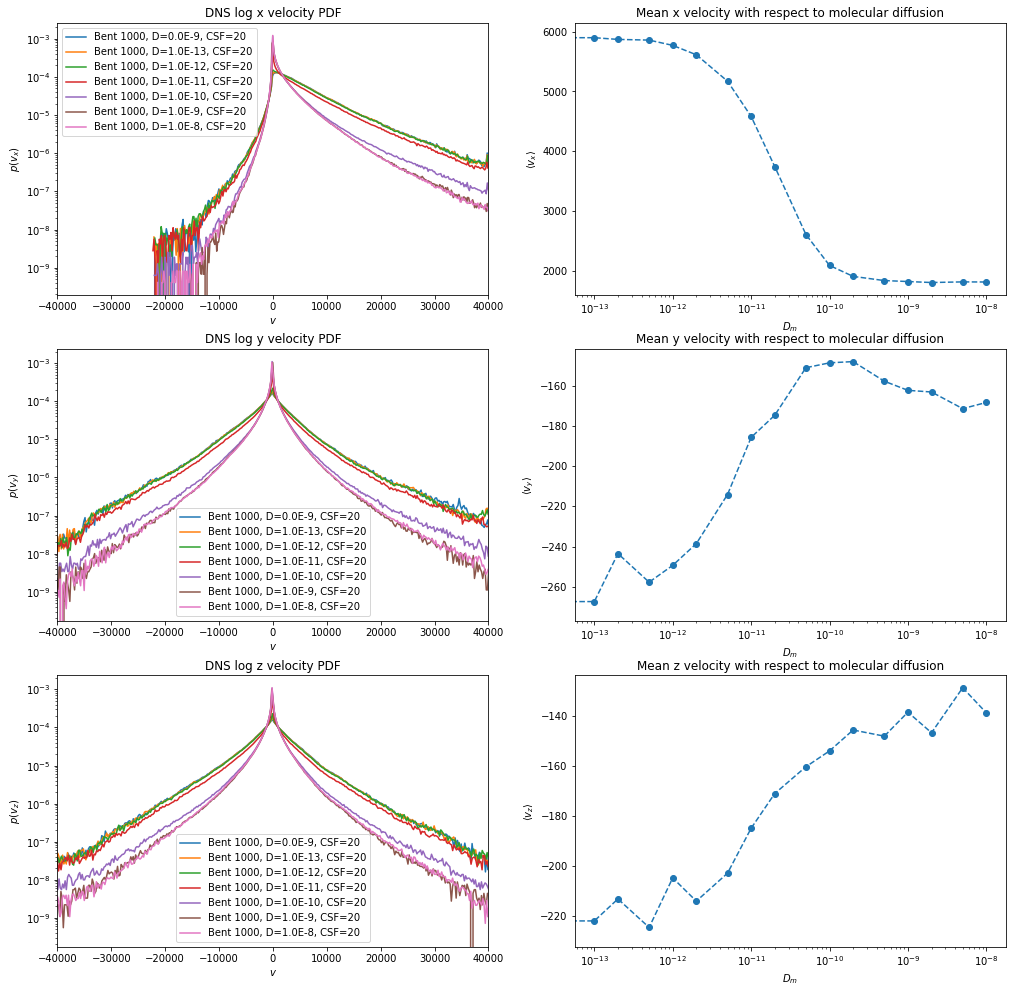

In [13]:
fig, axs = plt.subplots(3,2,figsize=(17,17))
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]

(i,j) = (0,0)
axs[i,j].set_title('DNS log x velocity PDF')
for key in PLOT_KEYS : axs[i,j].semilogy(pvx_DNS[key][0], pvx_DNS[key][1],label = key)
axs[i,j].legend();
axs[i,j].set_xlabel(r'$v$');
axs[i,j].set_ylabel(r'$p(v_x)$');
axs[i,j].set_xlim([-40000,40000]);

(i,j) = (1,0)
axs[i,j].set_title('DNS log y velocity PDF')
for key in PLOT_KEYS : axs[i,j].semilogy(pvy_DNS[key][0], pvy_DNS[key][1],label = key)
axs[i,j].legend();
axs[i,j].set_xlabel(r'$v$');
axs[i,j].set_ylabel(r'$p(v_y)$');
axs[i,j].set_xlim([-40000,40000]);

(i,j) = (2,0)
axs[i,j].set_title('DNS log z velocity PDF')
for key in PLOT_KEYS : axs[i,j].semilogy(pvz_DNS[key][0], pvz_DNS[key][1],label = key)
axs[i,j].legend();
axs[i,j].set_xlabel(r'$v$');
axs[i,j].set_ylabel(r'$p(v_z)$');
axs[i,j].set_xlim([-40000,40000]);

(i,j) = (0,1)
axs[i,j].set_title('Mean x velocity with respect to molecular diffusion')
axs[i,j].semilogx(D_VALUES,vxmean,'o--', color = color_cycle[0])
axs[i,j].set_xlabel(r'$D_m$');
axs[i,j].set_ylabel(r'$\langle v_x \rangle$');

(i,j) = (1,1)
axs[i,j].set_title('Mean y velocity with respect to molecular diffusion')
axs[i,j].semilogx(D_VALUES,vymean,'o--', color = color_cycle[0])
axs[i,j].set_xlabel(r'$D_m$');
axs[i,j].set_ylabel(r'$\langle v_y \rangle$')

(i,j) = (2,1)
axs[i,j].set_title('Mean z velocity with respect to molecular diffusion')
axs[i,j].semilogx(D_VALUES,vzmean,'o--', color = color_cycle[0])
axs[i,j].set_xlabel(r'$D_m$');
axs[i,j].set_ylabel(r'$\langle v_z \rangle$');

plt.savefig(DIR+'Figures/directional_speed_pdf'+extension)

#### Overview of the rough DNS time

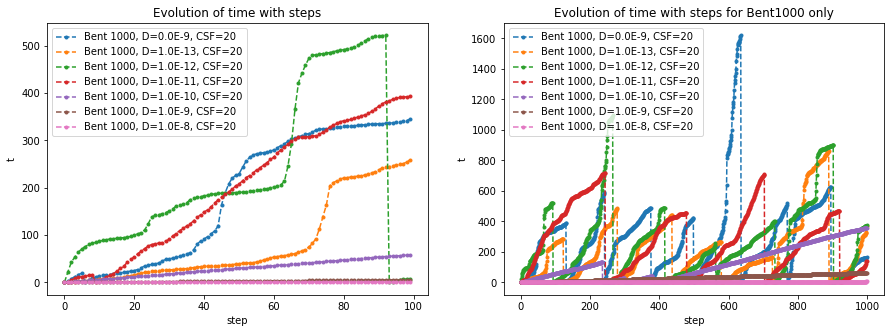

In [14]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]

axs[0].set_title('Evolution of time with steps');
for key in PLOT_KEYS : axs[0].plot(tDNS[key][range(100)],'.--', label = key);
axs[0].set_xlabel('step');
axs[0].set_ylabel('t');
axs[0].legend();

axs[1].set_title('Evolution of time with steps for Bent1000 only');
for key in PLOT_KEYS : axs[1].plot(tDNS[key][range(1000)],'.--', label = key);
axs[1].set_xlabel('step');
axs[1].set_ylabel('t');
axs[1].legend();
plt.savefig(DIR+'Figures/DNS_time'+extension)

## Making DNS data isochronous

### 1) Single streamline transform (ssl)

In [15]:
def ssl_transform(N,t,v) :
    dt      = [t1-t0 for (t1,t0) in zip(t[range(1,N)],t[range(N-1)])]
    dt_ssl  = [dt_ for dt_ in dt if dt_ > 0] #filtering
    N_ssl   = len(dt_ssl)
    t_ssl   = np.zeros(N_ssl)
    v_ssl   = np.zeros(N_ssl)
    #t_ssl  = [t_ssl[i-1] + dt_ssl[i] for i in range(1,N_ssl)]
    T = 0.0
    for i in range(N_ssl) :
        t_ssl[i] = T
        T += dt_ssl[i]
        v_ssl[i] = v[i]
    return t_ssl, v_ssl

In [16]:
dicts      = [{},{}]
v_ssl   = dicts[0]; vsslfname   = DIR+'Processed_data/v_ssl.dat'
t_ssl   = dicts[1]; tsslfname   = DIR+'Processed_data/t_ssl.dat'
fnames     = [vsslfname, tsslfname]

for i in range(len(fnames)) :
    name_ = fnames[i]
    if os.path.isfile(name_): 
        print('Loading ' + name_ + '..')
        dicts[i] = Load_data(name_)
    else : 
        print('Missing ' + name_ + '..')
        MISSING = True
    print('Done.')
v_ssl   = dicts[0];
t_ssl   = dicts[1];

RESAVE = False
print('Checking if new data file...')
for key in DATA :
    if key not in v_ssl :
        RESAVE = True
        print("missing " + key + "data..")
        Npoints = len(tDNS[key]) #For the full data set
        t_ssl[key], v_ssl[key] = ssl_transform (Npoints, tDNS[key], vDNS[key])
        print (key + '\t Npoints = '+str(Npoints))
        print('t_ssl : '+str(len(t_ssl[key]))+', v_ssl : ' + str(len(v_ssl[key])))
if RESAVE :
    print('Saving '+vsslfname+'...')
    Save_data(v_ssl,vsslfname)
    print('Saving '+tsslfname+'...')
    Save_data(t_ssl,tsslfname)
    print('Done.')    

Loading D:/pdm_data/Processed_data/v_ssl.dat..
Done.
Loading D:/pdm_data/Processed_data/t_ssl.dat..
Done.
Checking if new data file...


#### Distribution of time step 

In [17]:
def time_step_analysis(t_ssl,key) :
    dt         = [t1-t0 for (t1,t0) in zip(t_ssl[1:],t_ssl[:-1]) if t1-t0 > 0]
    dt_hist    = Extract_pdf(dt,50)
    dtDNS_mean = np.mean(dt)
    dtDNS_std  = np.std(dt)
    return (key, dt_hist, dtDNS_mean, dtDNS_std)
    
def parallel_time_step_analysis(t_dict) :
    dt_hist        = {}
    dtDNS_mean     = {}
    dtDNS_std      = {}
    results  = Parallel(n_jobs=-2)(delayed(time_step_analysis)(t_dict[key],key) for key in KEYS)
    for (k_,h_,m_,s_) in results :
        dt_hist[k_]    = h_.tolist()
        dtDNS_mean[k_] = [m_]
        dtDNS_std[k_]  = [s_]
    return dt_hist, dtDNS_mean, dtDNS_std

In [18]:
dt_histfname = DIR+'Processed_data/dt_hist.dat'
dtmeanfname  = DIR+'Processed_data/dt_mean.dat'
dtstdfname   = DIR+'Processed_data/dt_std.dat'
RERUN = False

if RERUN :
    start = time.time()
    dt_hist, dtDNS_mean, dtDNS_std = parallel_time_step_analysis(t_ssl)
    end = time.time()
    print('\tTime needed \t: '+str(end-start))
    print('Saving '+dt_histfname+'...')
    Save_pdf(dt_hist,dt_histfname)
    print('Saving '+dtmeanfname+'...')
    Save_data(dtDNS_mean,dtmeanfname)
    print('Saving '+dtstdfname+'...')
    Save_data(dtDNS_std,dtstdfname)
    print('Done.') 
else :
    dt_hist    = Load_pdf(dt_histfname)
    dtDNS_mean = Load_data(dtmeanfname)
    dtDNS_std  = Load_data(dtstdfname)

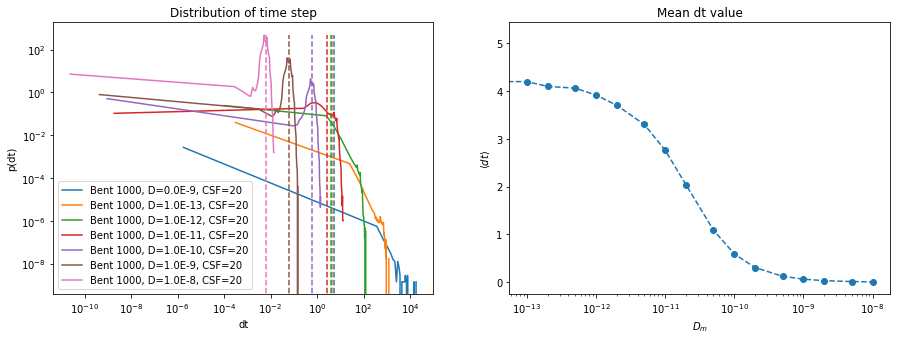

In [34]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]

k_ = 0
for key in PLOT_KEYS :
    axs[0].plot(dt_hist[key][0],dt_hist[key][1], label = key, color = color_cycle[k_])
    axs[0].plot(np.ones(2) * dtDNS_mean[key],np.linspace(0,500,2),'--', color = color_cycle[k_])
    k_ += 1
axs[0].set_title('Distribution of time step');
axs[0].set_xlabel('dt')
axs[0].set_ylabel('p(dt)')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend();

axs[1].set_title('Mean dt value')
axs[1].plot(D_VALUES,[dtDNS_mean[k_] for k_ in KEYS],'o--')
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$D_m$')
axs[1].set_ylabel(r'$\langle dt \rangle$')


plt.savefig(DIR+'Figures/DNS_dt_distribution'+extension)

#### Overview of the ssl transformed DNS serie

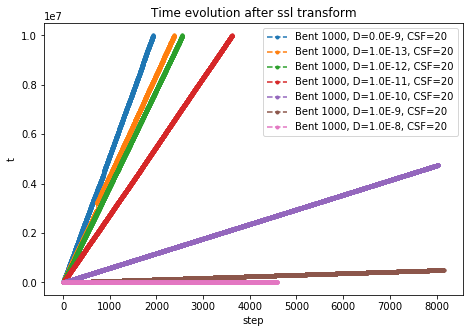

In [20]:
fig, ax = plt.subplots(1,1, figsize=(7.5,5))
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]

ax.set_title('Time evolution after ssl transform')
for key in PLOT_KEYS : ax.plot(t_ssl[key][range(0,len(t_ssl[key]),1000)],'.--', label = key);
ax.set_xlabel('step');
ax.set_ylabel('t');
ax.legend();
plt.savefig(DIR+'Figures/DNS_time_iso'+extension)

#### Isochronous transform of DNS data

In [21]:
#pointwise linear interpolation
def lin_interp(v1,t1,v0,t0,t) :
    v = v0 + (v1-v0) * (t-t0)/(t1-t0)
    return v
#Alternative version (parallel over dict keys) :
def isochronous_transform(t_serie, v_serie, dt, key, Npoints) :
    if Npoints == 'all' :
        N = len(t_serie)-1
    elif 0 < Npoints <= 1 :
        N = int(Npoints * (len(t_serie)-1))
    else :
        N = Npoints
    Nt_iso   = int(np.ceil(t_serie[N]/dt))
    v_iso    = np.zeros(Nt_iso)
    
    m = 0; i = 0; ti = 0;
    while(m < N-1) :
        t1 = t_serie[m+1]; t0 = t_serie[m]
        v1 = v_serie[m+1]; v0 = v_serie[m]
        while (t0 <= ti <= t1) :
            v_iso[i]  = lin_interp(v1,t1,v0,t0,ti)
            ti += dt; i += 1
        m = m + 1
    return (key,v_iso)

def parallel_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor) :
    v_iso    = Parallel(n_jobs=-2)(
        delayed(isochronous_transform)
        (t_dict[key], v_dict[key], dt_dict[key] * dt_factor, key, Npoints) for key in KEYS)
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

def sequential_isochronous_transform(t_dict, v_dict, dt_dict, Npoints, dt_factor) :
    v_iso = [isochronous_transform(t_dict[key], v_dict[key], dt_dict[key] * dt_factor, key, Npoints) for key in KEYS]
    v_iso_dict = {}
    for (key,v_) in v_iso :
        v_iso_dict[key] = v_.tolist()
    return v_iso_dict

In [22]:
#Dictionnary to store isochronous transforms with various dt
dt_factor = 1.0 #To choose the ratio between isochr dt and DNS mean dt
v_iso  = {}; vname = DIR+'Processed_data/v_iso_dt_fact_'+str(dt_factor)+'.dat';
t_iso  = {} #time (linspace(0,T,dt))
Nt_iso = {} #number of points
dt_iso = {}; dtname = DIR+'Processed_data/dt_iso_dt_fact_'+str(dt_factor)+'.dat';
RERUN  = True
SAVE   = False
Npoints = 'all'
if  (os.path.isfile(vname) and os.path.isfile(dtname)) and (not RERUN) :
    print('Load v_iso.dat...')
    v_iso = Load_data(vname)
    print('Load dt_iso.dat...')
    dt_iso = Load_data(dtname)
    print('Done.')
else :
    print('Isochronous transform..')
    start = time.time()
    v_iso  = parallel_isochronous_transform(t_ssl, v_ssl, dtDNS_mean, Npoints, dt_factor)
    #v_iso  = sequential_isochronous_transform(t_ssl, v_ssl, dtDNS_mean, Npoints, dt_factor)
    end = time.time()
    print('\tTime needed \t: '+str(end-start))
    SAVE = True

for key in KEYS :
    print(key+' :')
    Nt_iso[key]  = len(v_iso[key])
    dt  = dtDNS_mean[key]
    dt_iso[key] = dt*dt_factor
    dt_iso[key] = dt_iso[key].tolist()
    t_iso [key]  = np.linspace(0,tDNS[key][-1],Nt_iso[key])
    print('\t dt = '+str(dt))
    print('\t Nt_DNS = '+str(len(tDNS[key])))
    print('\t Nt_iso = '+str(Nt_iso[key]))
    print('\t Niso/Npoints inflation :'+str(100.0 * Nt_iso[key]/len(tDNS[key])))

Isochronous transform..
	Time needed 	: 189.18765377998352
Bent 1000, D=0.0E-9, CSF=20 :
	 dt = [5.17886565]
	 Nt_DNS = 1946689
	 Nt_iso = 1931010
	 Niso/Npoints inflation :99.19458115805863
Bent 1000, D=1.0E-13, CSF=20 :
	 dt = [4.19796179]
	 Nt_DNS = 2397176
	 Nt_iso = 2382105
	 Niso/Npoints inflation :99.37130189856731
Bent 1000, D=2.0E-13, CSF=20 :
	 dt = [4.09849321]
	 Nt_DNS = 2455302
	 Nt_iso = 2439921
	 Niso/Npoints inflation :99.37355974947278
Bent 1000, D=5.0E-13, CSF=20 :
	 dt = [4.06052827]
	 Nt_DNS = 2478275
	 Nt_iso = 2462844
	 Niso/Npoints inflation :99.37734916423722
Bent 1000, D=1.0E-12, CSF=20 :
	 dt = [3.91769138]
	 Nt_DNS = 2568389
	 Nt_iso = 2552508
	 Niso/Npoints inflation :99.38167466065303
Bent 1000, D=2.0E-12, CSF=20 :
	 dt = [3.70270781]
	 Nt_DNS = 2717415
	 Nt_iso = 2700725
	 Niso/Npoints inflation :99.38581335570754
Bent 1000, D=5.0E-12, CSF=20 :
	 dt = [3.30072881]
	 Nt_DNS = 3048554
	 Nt_iso = 3029629
	 Niso/Npoints inflation :99.37921388304095
Bent 1000, 

In [23]:
if SAVE :
    print('Saving data...')
    Save_data(v_iso,vname)
    Save_data(dt_iso,dtname)
    print('Done.')

Saving data...
Done.


#### Verification of the isochronous transform by comparing it to original data

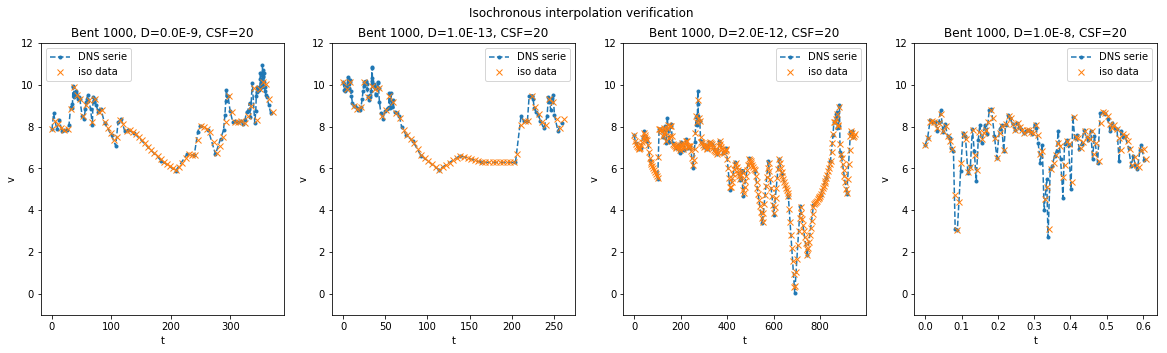

In [24]:
key    = KEYS[-1]
fig, axs = plt.subplots(1,4, figsize = (20,5))
fig.suptitle('Isochronous interpolation verification');

i0  = 0
N   = 100
for (i,key) in zip(range(4),[KEYS[0], KEYS[1],KEYS[5], KEYS[-1]]) :
    T0     = t_ssl[key][i0]
    T      = t_ssl[key][i0+N]
    axs[i].set_title(key)
    axs[i].plot(t_ssl[key][i0:i0+N],v_ssl[key][i0:i0+N],'.--', label = 'DNS serie'); #rough DNS series
    
    i0_iso = int(np.ceil(T0/dt_iso[key]))
    N_iso  = int(np.ceil((T-T0)/dt_iso[key]))
    t_iso  = np.linspace(T0,T,N_iso)
    axs[i].plot(t_iso,v_iso[key][i0_iso:i0_iso+N_iso],'x',label='iso data'); #Isochronous series

    axs[i].set_xlabel('t');
    axs[i].set_ylabel('v');
    axs[i].set_ylim([-1,12])
    axs[i].legend();
plt.savefig(DIR+'Figures/check_iso_transf'+extension)

## Comparison between the PDF before and after ssl isochronous transform

In [25]:
pdf_DNS     = {} #Log velocity magnitude probability density function extracted directly from DNS
pdf_iso     = {} #to store isochronous histogram as a line
vmean       = [] #Mean log velocity magnitude
vstd        = [] #Standard deviation
vskew       = [] #Skewness
MCT         = [] #Mean crossing time
vmean_iso   = [] #Mean log velocity magnitude

start = time.time()
for key in KEYS :
    pdf_DNS[key] = Extract_pdf(vDNS[key])
    pdf_iso[key] = Extract_pdf(v_iso[key]);
    MCT.append(mean_crossing_time(tDNS[key]))
    vmean.append(Return_mean(pdf_DNS[key]))
    vstd.append(Return_std(pdf_DNS[key]))
    vskew.append(Return_skew(pdf_DNS[key]))
    vmean_iso.append(Return_mean(pdf_iso[key]))
end = time.time()
print('\tTime needed \t: '+str(end-start))

	Time needed 	: 9.726673126220703


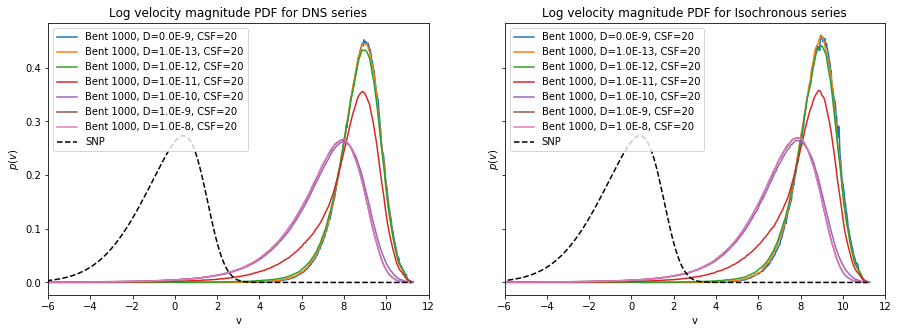

In [26]:
fig, axs = plt.subplots(1,2, figsize=(15,5), sharey=True);
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]
axs[0].set_title('DNS log velocity magnitude PDF')
axs[0].set_title('Log velocity magnitude PDF for DNS series');
axs[0].set_xlabel('v')
axs[0].set_ylabel(r'$p(v)$')
for key in PLOT_KEYS : 
    axs[0].plot(pdf_DNS[key][0],pdf_DNS[key][1], label=key);
axs[0].plot(pdf_DNS[key][0], p_skew(pdf_DNS[key][0],Bentheimer1000), '--k', label = 'SNP');
axs[0].legend();
axs[0].set_xlim([-6,12]);

axs[1].set_title('Log velocity magnitude PDF for Isochronous series');
axs[1].set_xlabel('v')
axs[1].set_ylabel(r'$p(v)$')
for key in PLOT_KEYS : 
    axs[1].plot(pdf_iso[key][0], pdf_iso[key][1], label=key)
axs[1].plot(pdf_iso[key][0], p_skew(pdf_iso[key][0],Bentheimer1000), '--k', label = 'SNP');
axs[1].legend();
axs[1].set_xlim([-6,12]);
plt.savefig(DIR+'Figures/DNS_vs_iso'+extension)

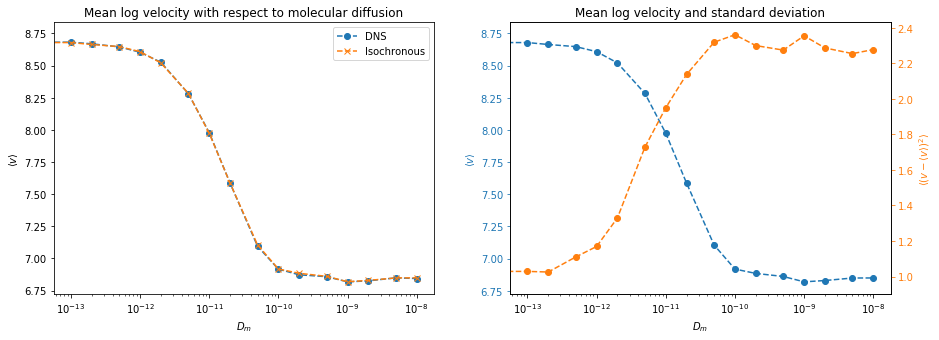

In [27]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

ax = axs[0]
ax.set_title('Mean log velocity with respect to molecular diffusion')
ax.semilogx(D_VALUES,vmean,'o--', color = color_cycle[0], label = 'DNS')
ax.semilogx(D_VALUES,vmean_iso,'x--', color = color_cycle[1], label = 'Isochronous')
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v \rangle$')
ax.legend();

ax = axs[1]
ax.set_title('Mean log velocity and standard deviation')
ax.semilogx(D_VALUES,vmean_iso,'o--', color = color_cycle[0])
ax.set_xlabel(r'$D_m$');
ax.set_ylabel(r'$\langle v \rangle$', color = color_cycle[0])
ax.tick_params('y', colors=color_cycle[0])

ax2 = ax.twinx()
ax2.semilogx(D_VALUES,vstd,'o--', color = color_cycle[1])
ax2.set_ylabel(r'$\langle (v - \langle v \rangle)^2 \rangle$', color = color_cycle[1])
ax2.tick_params('y', colors=color_cycle[1])

plt.savefig(DIR+'Figures/mean_v_to_dm'+extension)

#### Autocorrelation

We compute autocorrelation using the normalized estimator : 
$$ R(t_k= k dt) = \frac{1}{(N-k)\sigma^2}\sum_{t=0}^{N-k} (X_t-\mu)(X_{t+k}-\mu) $$

The cutting time $\tau_c$ that approach the distance between two closest uncorrelated measures is defined as the time where the tangent at $R(t_k=0)$ crosses the x-axis. 
This tangent is approximated as an $m$ points average slope as

$$ \partial R/\partial t|_{t_k=0} \approx \frac{R(t_m)-R(0)}{t_m - t_0} $$
leading to
$$ \tau_c = \frac{\Delta R}{\partial R/\partial t} \approx \frac{R(t_k=\tau_c)-R(t_k=0)}{(R(t_k=t_m) - R(t_k=0))/(t_m - t_0)}. $$

Per definition, $R(\tau_c)=0$ and $R(t_0=0)=1$ so the expression reduces to
$$ \tau_c = \frac{-t_m}{R(t_k=t_m)-1} $$

In [118]:
def autocorr_hm(x, Tmax, dt, Np, key) :
    mu    = np.mean(x)
    sigma = np.std(x)
    
    N     = len(x)
    Nk    = int(Tmax / dt)
    Nskip = max(1,Nk // Np)
    if Nskip == 1 : Np = min(Np,Nk)
    
    acf   = np.zeros(Np)
    trange= np.zeros(Np)
    i     = 0
    for i in range(Np):
        k = i*Nskip
        for t in range(0, N-k):
            acf[i] += 1.0/((N-k)*sigma**2)*(x[t]-mu)*(x[t+k]-mu)
        trange[i] = k*dt
    return (key, trange, acf) 

def parallel_autocorr(v_dict, Tmax = 0, Np = 50, Nmax = 1000, Nstart = 0) :
    v_autocorr = {}
    t_autocorr = {}
    results = Parallel(n_jobs=-2)(delayed(autocorr_hm)(v_dict[key][Nstart:Nmax], Tmax, dt_iso[key][0], Np, key) for key in KEYS)
    for (key, t_, v_) in results :
        t_autocorr[key] = t_
        v_autocorr[key] = v_
    return (t_autocorr,v_autocorr)

def extract_cutting_time(x, acf, Np = 10) :
    tau = -x[Np]/(acf[Np]-1)
    return tau

In [92]:
start = time.time()
Np   = 1000
Nmax = 20000
Tmax = 2000
Nstart = 10000
t_autocorr, v_autocorr = parallel_autocorr(v_iso, Tmax, Np, Nmax, Nstart)
end   = time.time()
print('\tTime needed \t: '+str(end-start))

	Time needed 	: 13.850090980529785


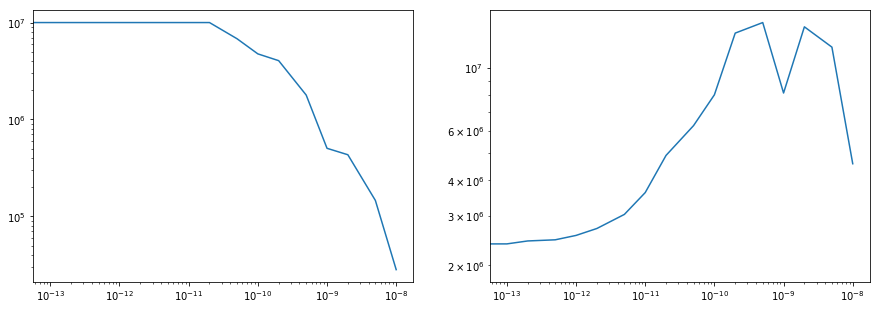

In [112]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].loglog(D_VALUES,[t_ssl[k_][-1] for k_ in KEYS])
axs[1].loglog(D_VALUES,[len(t_ssl[k_]) for k_ in KEYS])

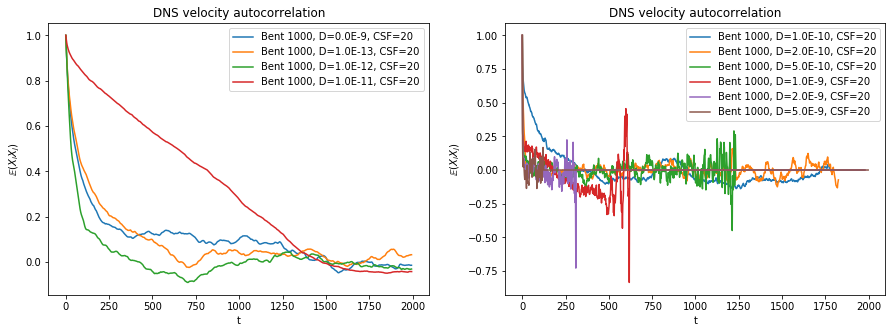

In [111]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

ax = axs[0]
ax.set_title('DNS velocity autocorrelation')
for key in PLOT_KEYS[0:4] :
    ax.plot(t_autocorr[key], v_autocorr[key], '-', label = key, color = COLORS[key])
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.legend();

ax = axs[1]
ax.set_title('DNS velocity autocorrelation')
for key in KEYS[10:-1] :
    ax.plot(t_autocorr[key], v_autocorr[key], '-', label = key)#, color = COLORS[key])
ax.set_xlabel('t')
ax.set_ylabel(r'$\mathbb{E}(X_i X_j)$')
ax.legend();
plt.savefig(DIR+'Figures/v_autocorr'+extension)

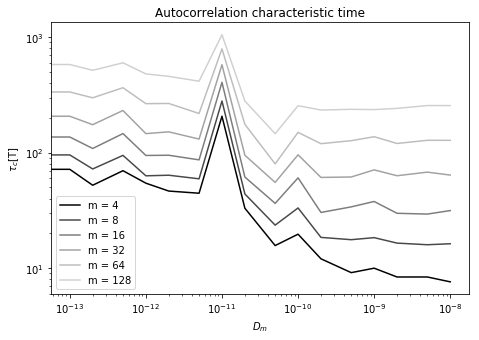

In [117]:
fig, ax = plt.subplots(1,1, figsize = (7.5,5.0))
ax.set_title('Autocorrelation characteristic time')
a_ = 1.0

for Np in [2**n for n in range(2,8)] :
    cutting_times = [extract_cutting_time(t_autocorr[key], v_autocorr[key], Np) for key in KEYS]
    ax.plot(D_VALUES, cutting_times,'-', label = 'm = '+str(Np), color ='k', alpha = a_)
    a_ /= 1.4

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$D_m$')
ax.set_ylabel(r'$\tau_c$[T]')
ax.legend();
plt.savefig(DIR+'Figures/autocorr_time'+extension)

## Modelization of the previous PDF

Behavior of mean log velocity and std are similar to function of the form :

$$ f(y; a_1,a_2,b,c) = \frac{a_1 \exp{[-c(y-b)]} + a_2 \exp{[c(y-b)]}}{\exp{[-c(y-b)]} + \exp{[c(y-b)}]} $$

where $a_1$,$a_2$ are left and right asymptotic behavior, respectively, $b$ the inflexion point position, $c$ the growth rate .

It can be useful to transform $f(x; a_1,a_2,b,c)$ into
$$ f(x; a_1,a_2,B,c) = \frac{a_1 B x^{-c} +  a_2 x^{c}}{B x^{-c} + x^{c}} $$
where $ x = e^y$ and $B = e^{2bc}$

In [26]:
def f(x,a1,a2,B,c) :
    up   = a1 * B * x**(-c) + a2 * x**c
    down = B * x**(-c) + x**c
    return up/down

Parameters found : $ v_a = 8.7, \quad v_d = 6.8, \quad b = \ln 10^{-11} $

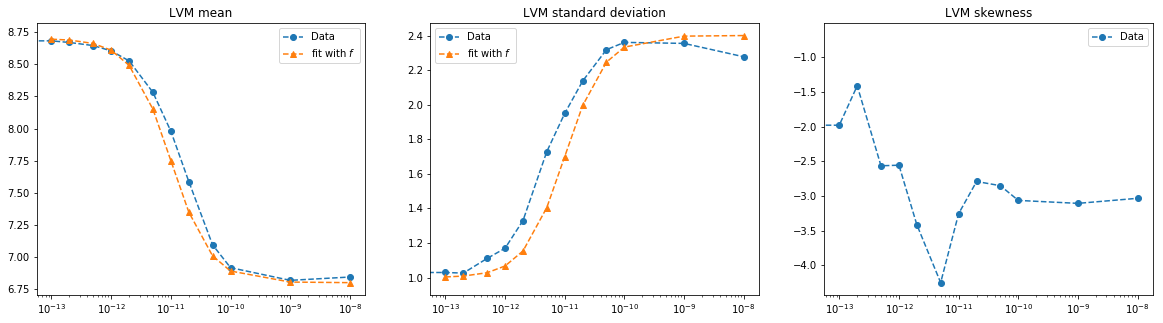

In [27]:
x = np.array([d_ for d_ in D_VALUES if d_ > 0])
va = 8.7; vd = 6.8;
b = np.log(1.0e-11); c  = 0.65; 
B = np.exp(2*b*c)
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].set_title('LVM mean')
axs[0].semilogx(D_VALUES,vmean,'o--', label='Data')
axs[0].semilogx(x,f(x,va,vd,B,c),'^--', label=r'fit with $f$')
axs[0].legend();

sm = 1.0; sp = 2.4;
axs[1].set_title('LVM standard deviation')
axs[1].semilogx(D_VALUES,vstd,'o--', label='Data')
axs[1].semilogx(x,f(x,sm,sp,B,c),'^--', label=r'fit with $f$')
axs[1].legend();

axs[2].set_title('LVM skewness')
axs[2].semilogx(D_VALUES,vskew,'o--', label='Data')
#axs[2].semilogx(x,f(x,sm,sp,B,c),'^--', label=r'fit with $f$')
axs[2].legend();

This behavior represent the variation of the mean of the skew normal pdf
$$ p(v; \mu, \sigma)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(v-\mu)^2}{2\sigma^2}\right](1-\textrm{erf}\left[-\frac{\alpha(v-\mu)}{\sqrt{2}\sigma}\right])$$
The mean, variance and skewness of skew normal pdf are given by 
$$\mu^* = \mu + \beta\sigma,\quad \sigma^* = \sigma \sqrt{ 1-\beta^2} \quad\textrm{and}\quad \alpha^* = \frac{4-\pi}{2}\frac{\beta^3}{(1-\beta^2)^{3/2}} \quad\textrm{with}\quad \beta := \sqrt{\frac{2}{\pi}}\frac{\alpha}{\sqrt{1+\alpha^2}}, $$
respectively

(Skewness defined as $\mathbb{E}\left[\left(\frac{X-\mu^*}{\sigma^*}\right)^3\right]$)

To fit our DNS pdf with skew normal pdf, the parameters $\mu,\sigma,\alpha$ must be set to reproduce the observed mean, variance and skewness of the data.
One can relate the skew normal pdf parameters $\mu,\sigma,\alpha$ to the mean, variance and skewness by inversing previous equations :
$$ \mu = \mu^* - \beta \sigma,\quad \sigma = \frac{\sigma^*}{\sqrt{1-\beta^2}} \quad\textrm{and}\quad \beta = \frac{\omega^*}{\sqrt{1+{\omega^*}^2}} \quad\textrm{with}\quad \omega^* :=\left(\frac{2}{4-\pi}\alpha^*\right)^{1/3}$$

The relation between the skewness $\alpha^*$ and our parameter $\alpha$ can be defined as :
$$  $$

In [34]:
print(np.sqrt(2.0/(np.pi-2.0)))

1.3236080967885127


In [167]:
def cbrt(x) :
    if x > 0 :
        return x**(1.0/3.0)
    else :
        return -((-x)**(1.0/3.0))

def beta_p(skew) :
    alpha = alpha_p(skew)
    return np.sqrt(2.0/np.pi)*alpha/np.sqrt(1+alpha**2)

def mu_p(avg, std, skew) :
    return avg - beta_p(skew) * var

def sigma_p(std, skew) :
    if beta_p(skew) < 1 :
        return var/np.sqrt(1-beta_p(skew))
    else :
        return var/np.sqrt(1+beta_p(skew))

def alpha_p(skew) :
    omega = cbrt(1.0*skew/(4.0-np.pi))
    if (1-2.0/np.pi)*omega**2 < 2.0/np.pi :
        return omega/np.sqrt(2.0/np.pi - (1-2.0/np.pi)*omega**2)
    else :
        return omega/np.sqrt(2.0/np.pi + (1-2.0/np.pi)*omega**2)
    
#Skew-normal PDF
def psk(v, avg, std, skew) :
    mu    = mu_p(avg, std, skew)
    sigma = sigma_p(std, skew)
    alpha = alpha_p(skew)
    return 1.0/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))

In [168]:
i = 0
v_stats = {}
for key in KEYS :
    tmp = {}
    tmp['avg']  = vmean[i]
    tmp['std']  = vstd[i]
    tmp['skew'] = vskew[i]
    v_stats[key] = tmp

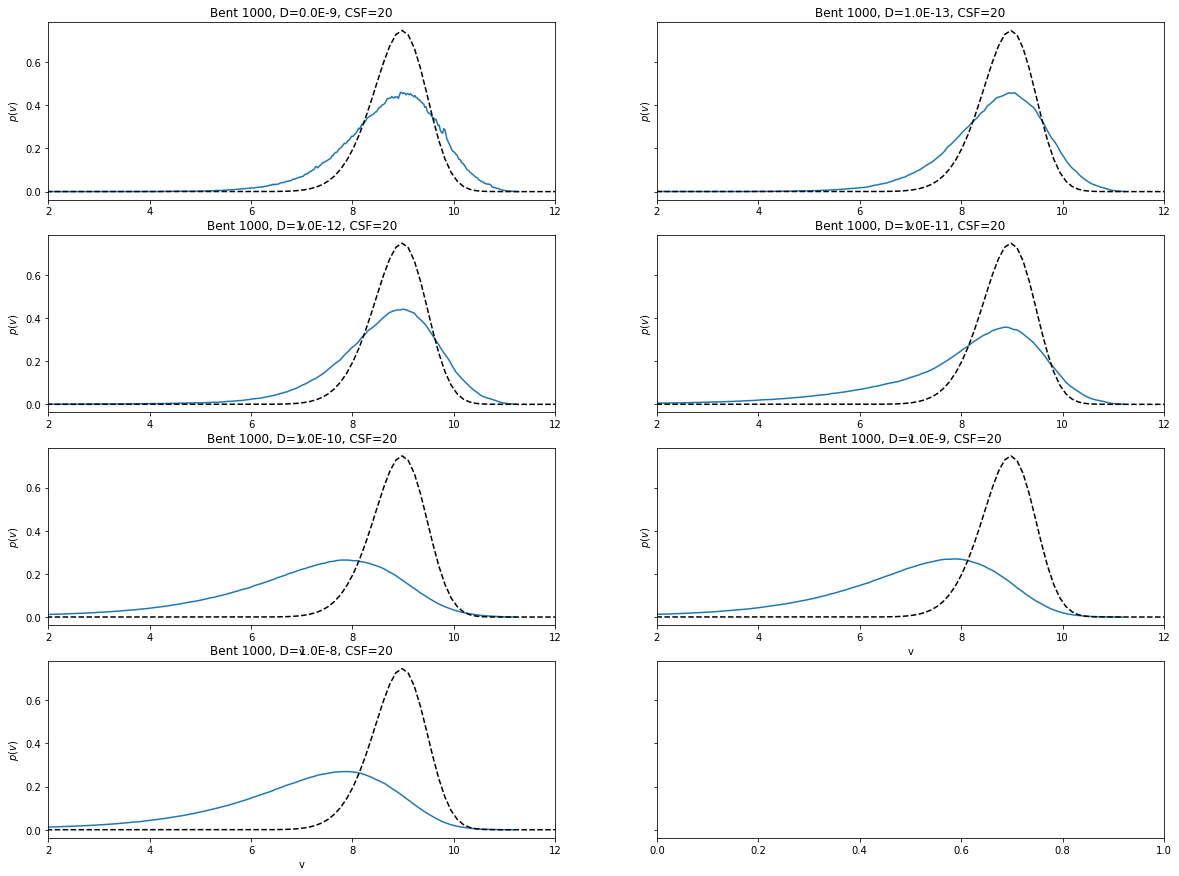

In [169]:
alpha = Bentheimer1000['alpha']
sigma = Bentheimer1000['sigma']
mu = Bentheimer1000['mu']
fig, axs = plt.subplots(4,2, figsize=(20,15), sharey=True);
PLOT_KEYS = ['Bent 1000, D='+dm_+', CSF=20' for dm_ in ['0.0E-9','1.0E-13', '1.0E-12','1.0E-11', '1.0E-10','1.0E-9','1.0E-8']]

count    = 0
for key in PLOT_KEYS :
    (i,j) = (int(count/2),np.mod(count,2))
    ax    = axs[i,j]
    ax.set_title(key);
    ax.plot(pdf_iso[key][0], pdf_iso[key][1])
    avg = v_stats[key]['avg']; std = v_stats[key]['std']; skew = v_stats[key]['skew']
    ax.plot(V, psk(V, avg, std, skew), '--k', label = 'SNP for D = '+str(d_))
    ax.set_xlim([2,12])
    ax.set_xlabel('v')
    ax.set_ylabel(r'$p(v)$')
    count += 1
    
plt.savefig(DIR+'Figures/DNS_vs_iso'+extension)

### Comparison with Markovian processes

In [107]:
samples = [Bentheimer1000]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=-2)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Loading data...')
    MP_lvm = Load_data(fname)
    print('Done')

Load data...
Done


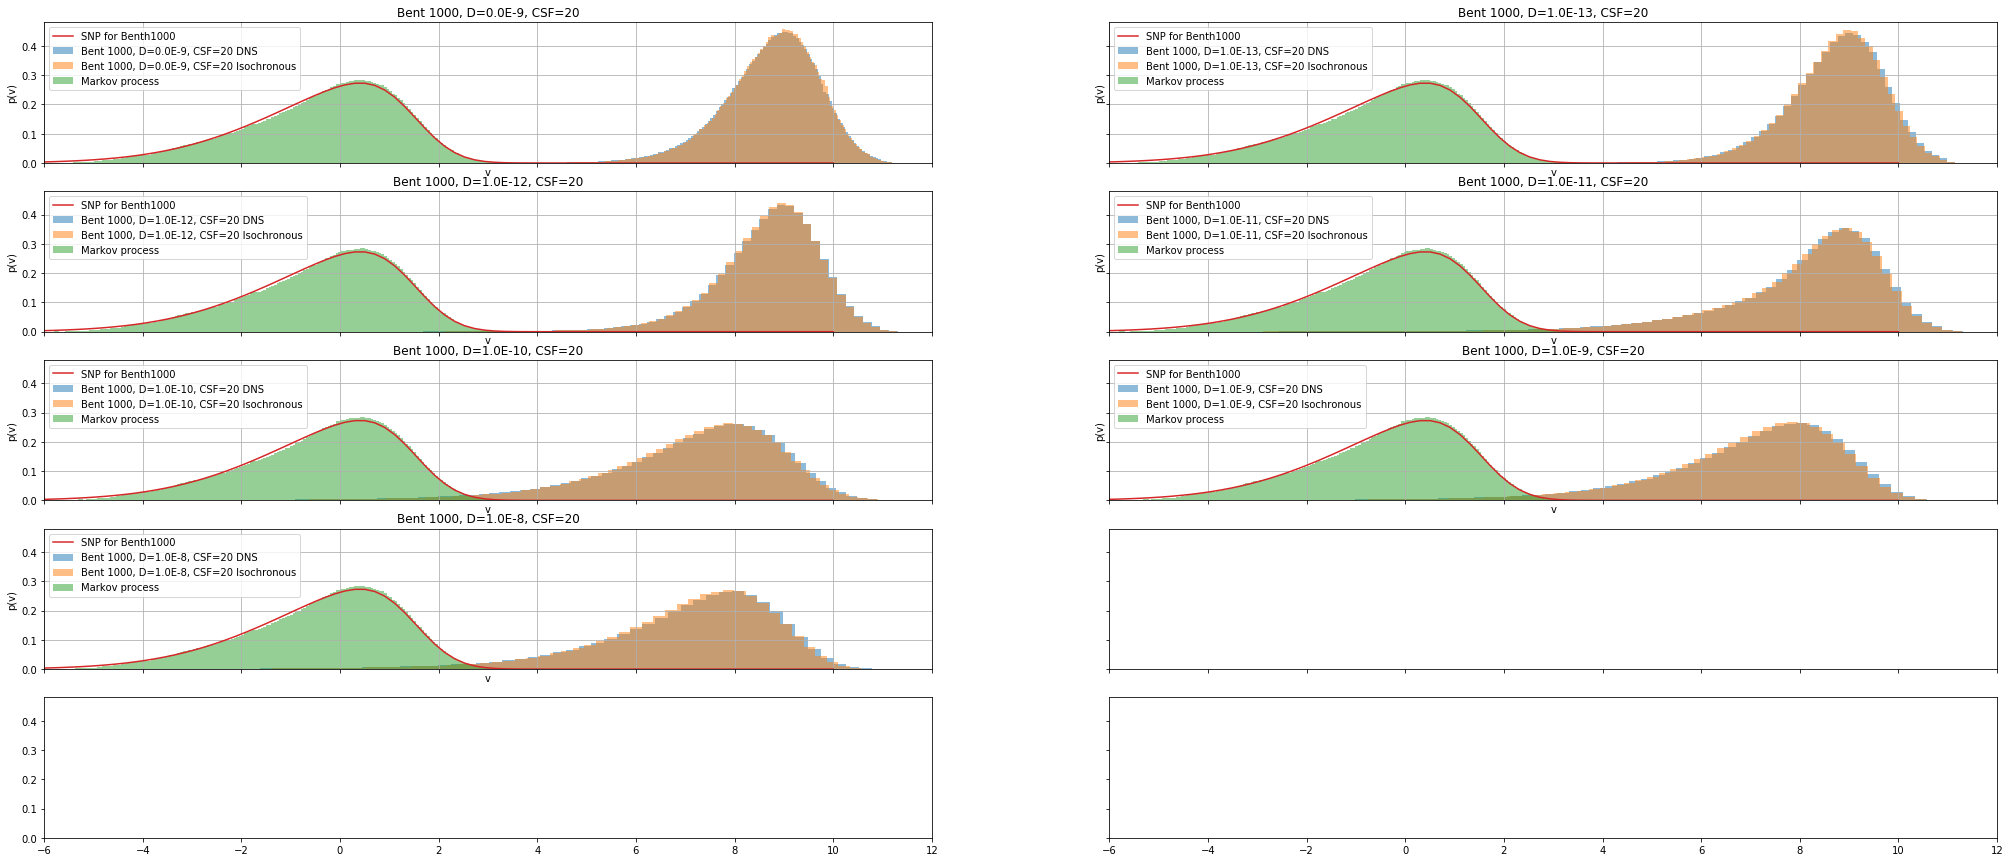

In [108]:
fig, axs = plt.subplots(5,2,figsize=(35,15), sharex=True, sharey=True)
sample   = Bentheimer1000
vrange = np.linspace(-10,10,100)
count    = 0
for key in PLOT_KEYS :
    data1 = vDNS[key]
    data2 = v_iso[key]
    data3 = MP_lvm[sample['name']]
    (i,j) = (int(count/2),np.mod(count,2))
    axs[i,j].set_title('' + key)
    axs[i,j].hist(data1, bins = 200, label = key+' DNS',         density = True, alpha= 0.5)
    axs[i,j].hist(data2, bins = 200, label = key+' Isochronous', density = True, alpha= 0.5)
    axs[i,j].hist(data3, bins = 200, label = 'Markov process',   density = True, alpha= 0.5)
    axs[i,j].plot(vrange, p_skew(vrange,sample), label = 'SNP for Benth1000');
    axs[i,j].grid(True)
    axs[i,j].set_xlabel('v')
    axs[i,j].set_ylabel('p(v)')
    axs[i,j].legend()
    axs[i,j].set_xlim([-6,12])
    count += 1
del data1, data2, data3
plt.savefig(DIR+'Figures/summary'+extension)